<a href="https://colab.research.google.com/github/JanePer/AI---PORTFOLIO/blob/main/Task6(Lite)_%D0%A0%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Оценка стоимости квартир

**1. Импорт библиотек**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import math
from google.colab import drive
from IPython.display import clear_output
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input, concatenate
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Загрузка базы данных квартир**

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/moscow.csv', sep=";")
df = df.iloc[::2,:]
df.head()

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."
6,1,Шаболовская м.,12п,8/12 ?,Б,Р,38/15/7,11200000.0,NaN,NaN,25.07.2019,7.0,Привлекательные,"Предлагаю 1- комн квартиру, в шаговой доступно..."
8,1,Бабушкинская м.,15п,4/14 П,NaN,С,34/17/8,6250000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,Продается хорошая 1 комнатная квартира. 1 взро...


In [ ]:
df.columns

Index(['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'ГРМ', 'Бонус агенту', 'Дата',
       'Кол-во дней в экспозиции', 'Источник', 'Примечание'],
      dtype='object')

**3. Очистка и парсинг данных**

In [ ]:
apartments=df[['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'Примечание']].copy()
apartments.reset_index(inplace=True, drop=True)
apartments.head()

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,Собственность оформлена! Ключи на руках! Опера...
1,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,Зеленоград к.1820 однокомнатная квартира общ.3...
2,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,"Уютная, светлая квартира, застекленный балкон ..."
3,1,Шаболовская м.,12п,8/12 ?,Б,Р,38/15/7,11200000.0,"Предлагаю 1- комн квартиру, в шаговой доступно..."
4,1,Бабушкинская м.,15п,4/14 П,NaN,С,34/17/8,6250000.0,Продается хорошая 1 комнатная квартира. 1 взро...


In [ ]:
apartments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126268 entries, 0 to 126267
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Комнат              126262 non-null  object 
 1   Метро / ЖД станции  125934 non-null  object 
 2   От станции          124539 non-null  object 
 3   Дом                 126268 non-null  object 
 4   Балкон              48069 non-null   object 
 5   Санузел             79559 non-null   object 
 6   Площадь             126268 non-null  object 
 7   Цена, руб.          126268 non-null  float64
 8   Примечание          125270 non-null  object 
dtypes: float64(1), object(8)
memory usage: 8.7+ MB


In [ ]:
apartments['Комнат'].value_counts()

1         62504
2         40962
Ст         8889
5          7044
6          2772
01.мар     1588
01.апр      566
01.фев      498
7           445
02.мар      197
8           183
01.май       96
02.апр       80
9            77
01.июн       71
10           58
01.янв       49
03.апр       24
02.май       22
01.июл       21
02.июн       14
01.сен       12
12           10
04.май        9
03.май        9
14            8
11            8
03.июн        6
13            5
03.авг        5
02.июл        4
15            4
16            4
05.июн        3
20            2
4             2
01.окт        2
04.июн        2
01.дек        2
30            1
02.фев        1
03.мар        1
01.авг        1
03.июл        1
Name: Комнат, dtype: int64

In [ ]:
#Формируем датасет только для 1 комн квартир (1 комн + студии) иначе база будет несбалансированной
oneroom=(apartments['Комнат']=='1') | (apartments['Комнат']=='Ст')
oneroom_apart=apartments[oneroom].copy()
oneroom_apart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71393 entries, 0 to 126267
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Комнат              71393 non-null  object 
 1   Метро / ЖД станции  71142 non-null  object 
 2   От станции          70207 non-null  object 
 3   Дом                 71393 non-null  object 
 4   Балкон              25244 non-null  object 
 5   Санузел             46852 non-null  object 
 6   Площадь             71393 non-null  object 
 7   Цена, руб.          71393 non-null  float64
 8   Примечание          70855 non-null  object 
dtypes: float64(1), object(8)
memory usage: 5.4+ MB


In [ ]:
oneroom_apart['Метро / ЖД станции']=oneroom_apart['Метро / ЖД станции'].str.lower().str.replace("метро",'').str.replace(" м.",'').str.replace("'",'').str.replace("(мцк)",'').str.replace("(",'').str.replace(")",'').str.strip()
allMetroNames=oneroom_apart['Метро / ЖД станции'].unique()
allMetroNames=allMetroNames.tolist()
allMetroNames[:10]

['шелепиха',
 'пятницкое шоссе',
 'планерная',
 'шаболовская',
 'бабушкинская',
 'улица дмитриевского',
 'бульвар рокоссовского',
 'марьина роща',
 'марьино',
 'печатники']

In [ ]:
len(allMetroNames)

256

In [ ]:
#Получаем индекс станции метро
def getMetro(metro_name):
  metro=0
  if metro_name in allMetroNames:
    metro=allMetroNames.index(metro_name)+1
  metro = utils.to_categorical(metro, len(allMetroNames)+1)
  return metro

oneroom_apart['Metro']=oneroom_apart['Метро / ЖД станции'].apply(getMetro)
oneroom_apart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71393 entries, 0 to 126267
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Комнат              71393 non-null  object 
 1   Метро / ЖД станции  71142 non-null  object 
 2   От станции          70207 non-null  object 
 3   Дом                 71393 non-null  object 
 4   Балкон              25244 non-null  object 
 5   Санузел             46852 non-null  object 
 6   Площадь             71393 non-null  object 
 7   Цена, руб.          71393 non-null  float64
 8   Примечание          70855 non-null  object 
 9   Metro               71393 non-null  object 
dtypes: float64(1), object(9)
memory usage: 6.0+ MB


In [ ]:
oneroom_apart.head()

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",Примечание,Metro
0,1,шелепиха,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,Собственность оформлена! Ключи на руках! Опера...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,пятницкое шоссе,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,Зеленоград к.1820 однокомнатная квартира общ.3...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,планерная,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,"Уютная, светлая квартира, застекленный балкон ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,шаболовская,12п,8/12 ?,Б,Р,38/15/7,11200000.0,"Предлагаю 1- комн квартиру, в шаговой доступно...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,бабушкинская,15п,4/14 П,NaN,С,34/17/8,6250000.0,Продается хорошая 1 комнатная квартира. 1 взро...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


In [ ]:
#Вычисляем растояние до метро
#pd.set_option('display.max_rows', 500)
oneroom_apart['От станции'].value_counts()

3т     7647
10п    5513
15п    4295
2т     4011
5п     3848
       ... 
58п       1
70т       1
54п       1
71п       1
34п       1
Name: От станции, Length: 104, dtype: int64

In [ ]:
def getMetroDistance(metrodiststr):
  metroDistance = 0 #Расстояние до метро
  metroDistanceType = 0 #Тип расстояния - пешком или на транспорте
  if (metrodiststr == metrodiststr):
    if len(metrodiststr)>0:
      if metrodiststr[-1]=='п':
        metroDistanceType=1
      elif metrodiststr[-1]=='т':
        metroDistanceType=2
    
      metrodiststr=metrodiststr[:-1]
      try:
        metroDistance=int(metrodiststr)
        if metroDistance<3:
          metroDistance=1
        elif metroDistance<6:
          metroDistance=2
        elif metroDistance<10:
          metroDistance=3
        elif metroDistance<15:
          metroDistance=4
        elif metroDistance<20:
          metroDistance=5
        else:
          metroDistance=6
      except:
        metroDistance=0

  metroDistanceClasses = 7
  if metroDistanceType == 2:
    metroDistance += metroDistanceClasses
  if metroDistanceType == 0:
    metroDistance += 2*metroDistanceClasses
  
  metroDistance = utils.to_categorical(metroDistance, 2*metroDistanceClasses+1)
  return metroDistance

oneroom_apart['metroDistance']=oneroom_apart['От станции'].apply(getMetroDistance)
oneroom_apart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71393 entries, 0 to 126267
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Комнат              71393 non-null  object 
 1   Метро / ЖД станции  71142 non-null  object 
 2   От станции          70207 non-null  object 
 3   Дом                 71393 non-null  object 
 4   Балкон              25244 non-null  object 
 5   Санузел             46852 non-null  object 
 6   Площадь             71393 non-null  object 
 7   Цена, руб.          71393 non-null  float64
 8   Примечание          70855 non-null  object 
 9   Metro               71393 non-null  object 
 10  metroDistance       71393 non-null  object 
dtypes: float64(1), object(10)
memory usage: 6.5+ MB


In [ ]:
oneroom_apart.head()

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",Примечание,Metro,metroDistance
0,1,шелепиха,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,Собственность оформлена! Ключи на руках! Опера...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,пятницкое шоссе,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,Зеленоград к.1820 однокомнатная квартира общ.3...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,планерная,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,"Уютная, светлая квартира, застекленный балкон ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,шаболовская,12п,8/12 ?,Б,Р,38/15/7,11200000.0,"Предлагаю 1- комн квартиру, в шаговой доступно...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,бабушкинская,15п,4/14 П,NaN,С,34/17/8,6250000.0,Продается хорошая 1 комнатная квартира. 1 взро...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


In [ ]:
oneroom_apart['Дом'].value_counts()

1/5 К        685
1/9 П        655
2/17 П       485
1/12 П       438
1/16 П       373
            ... 
32/33 М-К      1
20/35 П        1
30/85 ?        1
24/56 М        1
34/58 ?        1
Name: Дом, Length: 3777, dtype: int64

In [ ]:
def getHouseTypeAndFloor(houseStr):
  houseType = 0 #Тип дома
  floor = 0 #Этаж квартиры
  floors = 0 #Этажность дома
  isLastFloor = 0 #Индикатор последнего этажа

  if (houseStr == houseStr):
    if (len(houseStr) > 1):
      slashIndex = houseStr.index("/") #Ищем разделитель /
      spaceIndex = houseStr.index(" ") #Ищем разделитель " "
      
      floorStr = houseStr[:slashIndex] #Строка этажа
      floorsStr = houseStr[slashIndex+1:spaceIndex] #Строка этажнгости дома
      houseTypeStr = houseStr[spaceIndex+1:] #Строка типа дома
      #Выбираем категорию этажа
      try:
        floor = int(floorStr) #Превращаем строку в число
        floorSave = floor
        if (floorSave == 1): #Первый этаж выделяем в отдельную категорию
          floor = 1 
        elif (floorSave < 5):
          floor = 2
        elif (floorSave < 10):
          floor = 3
        elif (floorSave < 20):
          floor = 4
        elif (floorSave >= 20):
          floor = 5

        if (int(floorStr) == int(floorsStr)): #Если этаж последний, включаем индикатор последнего этажа
          isLastFloor = 1 
      except:
        floor = 0 #Если строка не парсится в число, то категория этажа = 0 (отдельная)

        #Выбираем категорию этажности дома
      try:
        floors = int(floorsStr) #Превращаем строку в число
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        elif (floorsSave < 10):
          floors = 2
        elif (floorsSave < 20):
          floors = 3
        elif (floorsSave >= 20):
          floors = 4
      except:
        floors = 0 #Если строка не парсится в число, то категория этажности = 0 (отдельная)

      #Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        elif ("К" in houseTypeStr): 
          houseType = 2
        elif ("П" in houseTypeStr): 
          houseType = 3
        elif ("Б" in houseTypeStr): 
          houseType = 4
        elif ("?" in houseTypeStr): 
          houseType = 5
        elif ("-" in houseTypeStr): 
          houseType = 6
    #Превращаем все категории в one hot encoding
    floor = utils.to_categorical(floor, 6).tolist()
    floors = utils.to_categorical(floors, 5).tolist()
    houseType = utils.to_categorical(houseType, 7).tolist()
    isLastFloor = utils.to_categorical(isLastFloor, 2).tolist()

  return floor+floors+isLastFloor+houseType

oneroom_apart['House']=oneroom_apart['Дом'].apply(getHouseTypeAndFloor)
oneroom_apart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71393 entries, 0 to 126267
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Комнат              71393 non-null  object 
 1   Метро / ЖД станции  71142 non-null  object 
 2   От станции          70207 non-null  object 
 3   Дом                 71393 non-null  object 
 4   Балкон              25244 non-null  object 
 5   Санузел             46852 non-null  object 
 6   Площадь             71393 non-null  object 
 7   Цена, руб.          71393 non-null  float64
 8   Примечание          70855 non-null  object 
 9   Metro               71393 non-null  object 
 10  metroDistance       71393 non-null  object 
 11  House               71393 non-null  object 
dtypes: float64(1), object(11)
memory usage: 7.1+ MB


In [ ]:
oneroom_apart.head()

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",Примечание,Metro,metroDistance,House
0,1,шелепиха,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,Собственность оформлена! Ключи на руках! Опера...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,1,пятницкое шоссе,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,Зеленоград к.1820 однокомнатная квартира общ.3...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,планерная,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,"Уютная, светлая квартира, застекленный балкон ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,шаболовская,12п,8/12 ?,Б,Р,38/15/7,11200000.0,"Предлагаю 1- комн квартиру, в шаговой доступно...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,бабушкинская,15п,4/14 П,NaN,С,34/17/8,6250000.0,Продается хорошая 1 комнатная квартира. 1 взро...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
balconyVariants=oneroom_apart['Балкон'].value_counts().index.tolist()
balconyVariants

['Л',
 'Б',
 '-',
 'БЛ',
 '2Л',
 '2Б',
 '3Б',
 '2Б2Л',
 'Эрк',
 '3Л',
 'Б2Л',
 '4Л',
 'ЭркЛ']

In [ ]:
#Вычисляем тип балкона
def getBalcony(balconyStr):
  if (balconyStr == balconyStr):
    balcony = balconyVariants.index(balconyStr)+1 #Находим индекс строки балкона во всех строках
  else:
    balcony = 0 #Индекс 0 выделяем на строку nan

  balcony = utils.to_categorical(balcony, len(balconyVariants)+1)
  return balcony

oneroom_apart['Balcony']=oneroom_apart['Балкон'].apply(getBalcony)
oneroom_apart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71393 entries, 0 to 126267
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Комнат              71393 non-null  object 
 1   Метро / ЖД станции  71142 non-null  object 
 2   От станции          70207 non-null  object 
 3   Дом                 71393 non-null  object 
 4   Балкон              25244 non-null  object 
 5   Санузел             46852 non-null  object 
 6   Площадь             71393 non-null  object 
 7   Цена, руб.          71393 non-null  float64
 8   Примечание          70855 non-null  object 
 9   Metro               71393 non-null  object 
 10  metroDistance       71393 non-null  object 
 11  House               71393 non-null  object 
 12  Balcony             71393 non-null  object 
dtypes: float64(1), object(12)
memory usage: 7.6+ MB


In [ ]:
oneroom_apart.head()

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",Примечание,Metro,metroDistance,House,Balcony
0,1,шелепиха,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,Собственность оформлена! Ключи на руках! Опера...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,пятницкое шоссе,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,Зеленоград к.1820 однокомнатная квартира общ.3...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,планерная,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,"Уютная, светлая квартира, застекленный балкон ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,шаболовская,12п,8/12 ?,Б,Р,38/15/7,11200000.0,"Предлагаю 1- комн квартиру, в шаговой доступно...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,бабушкинская,15п,4/14 П,NaN,С,34/17/8,6250000.0,Продается хорошая 1 комнатная квартира. 1 взро...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
wcVariants=oneroom_apart['Санузел'].value_counts().index.tolist()
wcVariants

['С', 'Р', '2', '-', '+', '2С', '2Р', '3', '3С', '4Р', '4', '3Р', '4С']

In [ ]:
#Определяем тип санузла
def getWC(wcStr):
  if (wcStr == wcStr):
    wc = wcVariants.index(wcStr)+1 #Находим индекс строки балкона во всех строках
  else:
    wc = 0 #Индекс 0 выделяем на строку nan

  wc = utils.to_categorical(wc, len(wcVariants)+1)
  return wc

oneroom_apart['WC']=oneroom_apart['Санузел'].apply(getWC)
oneroom_apart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71393 entries, 0 to 126267
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Комнат              71393 non-null  object 
 1   Метро / ЖД станции  71142 non-null  object 
 2   От станции          70207 non-null  object 
 3   Дом                 71393 non-null  object 
 4   Балкон              25244 non-null  object 
 5   Санузел             46852 non-null  object 
 6   Площадь             71393 non-null  object 
 7   Цена, руб.          71393 non-null  float64
 8   Примечание          70855 non-null  object 
 9   Metro               71393 non-null  object 
 10  metroDistance       71393 non-null  object 
 11  House               71393 non-null  object 
 12  Balcony             71393 non-null  object 
 13  WC                  71393 non-null  object 
dtypes: float64(1), object(13)
memory usage: 8.2+ MB


In [ ]:
oneroom_apart.head()

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",Примечание,Metro,metroDistance,House,Balcony,WC
0,1,шелепиха,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,Собственность оформлена! Ключи на руках! Опера...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,пятницкое шоссе,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,Зеленоград к.1820 однокомнатная квартира общ.3...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,планерная,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,"Уютная, светлая квартира, застекленный балкон ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,шаболовская,12п,8/12 ?,Б,Р,38/15/7,11200000.0,"Предлагаю 1- комн квартиру, в шаговой доступно...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,бабушкинская,15п,4/14 П,NaN,С,34/17/8,6250000.0,Продается хорошая 1 комнатная квартира. 1 взро...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
#Определяем общую площадь
def getArea(areaStr):
  if ("/" in areaStr):
    slashIndex = areaStr.index("/") #Находим разделитель /
    try:
      area = float(areaStr[:slashIndex]) #Берём число до разделителя и превращаем в число
    except:
      area = 0 #Если не получается, возвращаем 0
  else:
    area = 0 #Или если нет разделителя, возвращаем 0
    
  return area

oneroom_apart['Area']=oneroom_apart['Площадь'].apply(getArea)
oneroom_apart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71393 entries, 0 to 126267
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Комнат              71393 non-null  object 
 1   Метро / ЖД станции  71142 non-null  object 
 2   От станции          70207 non-null  object 
 3   Дом                 71393 non-null  object 
 4   Балкон              25244 non-null  object 
 5   Санузел             46852 non-null  object 
 6   Площадь             71393 non-null  object 
 7   Цена, руб.          71393 non-null  float64
 8   Примечание          70855 non-null  object 
 9   Metro               71393 non-null  object 
 10  metroDistance       71393 non-null  object 
 11  House               71393 non-null  object 
 12  Balcony             71393 non-null  object 
 13  WC                  71393 non-null  object 
 14  Area                71393 non-null  float64
dtypes: float64(2), object(13)
memory usage: 8.7+ MB


In [ ]:
oneroom_apart.head()

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",Примечание,Metro,metroDistance,House,Balcony,WC,Area
0,1,шелепиха,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,Собственность оформлена! Ключи на руках! Опера...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",64.1
1,1,пятницкое шоссе,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,Зеленоград к.1820 однокомнатная квартира общ.3...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",38.4
2,1,планерная,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,"Уютная, светлая квартира, застекленный балкон ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",38.2
3,1,шаболовская,12п,8/12 ?,Б,Р,38/15/7,11200000.0,"Предлагаю 1- комн квартиру, в шаговой доступно...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",38.0
4,1,бабушкинская,15п,4/14 П,NaN,С,34/17/8,6250000.0,Продается хорошая 1 комнатная квартира. 1 взро...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",34.0


In [ ]:
#Полуаем цену
def getCost(costStr):
  try:
    cost = float(costStr) #Пробуем превратить в число
  except:
    cost = 0 #Если не получается, возвращаем 0
  return cost

oneroom_apart['Cost']=oneroom_apart['Цена, руб.'].apply(getCost)
oneroom_apart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71393 entries, 0 to 126267
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Комнат              71393 non-null  object 
 1   Метро / ЖД станции  71142 non-null  object 
 2   От станции          70207 non-null  object 
 3   Дом                 71393 non-null  object 
 4   Балкон              25244 non-null  object 
 5   Санузел             46852 non-null  object 
 6   Площадь             71393 non-null  object 
 7   Цена, руб.          71393 non-null  float64
 8   Примечание          70855 non-null  object 
 9   Metro               71393 non-null  object 
 10  metroDistance       71393 non-null  object 
 11  House               71393 non-null  object 
 12  Balcony             71393 non-null  object 
 13  WC                  71393 non-null  object 
 14  Area                71393 non-null  float64
 15  Cost                71393 non-null  float64
dtypes: 

In [ ]:
oneroom_apart.head()

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",Примечание,Metro,metroDistance,House,Balcony,WC,Area,Cost
0,1,шелепиха,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,Собственность оформлена! Ключи на руках! Опера...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",64.1,19500000.0
1,1,пятницкое шоссе,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,Зеленоград к.1820 однокомнатная квартира общ.3...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",38.4,4800000.0
2,1,планерная,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,"Уютная, светлая квартира, застекленный балкон ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",38.2,7990000.0
3,1,шаболовская,12п,8/12 ?,Б,Р,38/15/7,11200000.0,"Предлагаю 1- комн квартиру, в шаговой доступно...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",38.0,11200000.0
4,1,бабушкинская,15п,4/14 П,NaN,С,34/17/8,6250000.0,Продается хорошая 1 комнатная квартира. 1 взро...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",34.0,6250000.0


In [ ]:
def text2Words(text):
  text=str(text)
  #Удаляем лишние символы
  text = text.replace(".", "")# удаляем лишние символы
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower() #Переводим в нижний регистр

  words = [] #Тут будут все слов
  currWord = "" #Тут будет накапливаться текущее слово, между двумя пробелами

  #идём по всем символам
  for symbol in text:
    
    if (symbol != "\ufeff"): #Игнорируем системынй символ в начале строки
      if (symbol != " "): #Если символ не пробел
        currWord += symbol #То добавляем вимвол в текущее слово
      else: #Если символ пробел
        if (currWord != ""): 
          words.append(currWord) #Добавляем тккущее слово в список слов
          currWord = "" #И обнуляем текущее слово

  #Добавляем финальное слово, если оно не пустое
  #Если не сделать, то потеряем финальное слово, потому что текст чаще всего заканчивается на не пробел
  if (currWord != ""):
        words.append(currWord)
  
  return words

oneroom_apart['Text']=oneroom_apart['Примечание'].apply(text2Words)
oneroom_apart.head()

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",Примечание,Metro,metroDistance,House,Balcony,WC,Area,Cost,Text
0,1,шелепиха,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,Собственность оформлена! Ключи на руках! Опера...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",64.1,19500000.0,"[собственность, оформлена, ключи, на, руках, о..."
1,1,пятницкое шоссе,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,Зеленоград к.1820 однокомнатная квартира общ.3...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",38.4,4800000.0,"[зеленоград, к1820, однокомнатная, квартира, о..."
2,1,планерная,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,"Уютная, светлая квартира, застекленный балкон ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",38.2,7990000.0,"[уютная, светлая, квартира, застекленный, балк..."
3,1,шаболовская,12п,8/12 ?,Б,Р,38/15/7,11200000.0,"Предлагаю 1- комн квартиру, в шаговой доступно...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",38.0,11200000.0,"[предлагаю, 1-, комн, квартиру, в, шаговой, до..."
4,1,бабушкинская,15п,4/14 П,NaN,С,34/17/8,6250000.0,Продается хорошая 1 комнатная квартира. 1 взро...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",34.0,6250000.0,"[продается, хорошая, 1, комнатная, квартира, 1..."


**4. Формируем обучающую выборку**

In [ ]:
data = oneroom_apart.values
data.shape

(71393, 17)

In [ ]:
x_train=[]
y_train=[]
x_train_text=[]
for d in data:
  metro=d[9].tolist()
  metrodistance=d[10].tolist()
  house=d[11]
  balcony=d[12].tolist()
  wc=d[13].tolist()
  area=d[14]
  cost=d[15]
  text=d[16]
  raw=metro+metrodistance+house+balcony+wc
  raw.append(area)
  x_train.append(raw)
  y_train.append(cost)
  x_train_text.append(text)

print(len(x_train))
print(len(y_train))
print(len(x_train_text))

71393
71393
71393


**5. Преобразование Текста в BOW**

In [ ]:
max_words_qty=2000
toks=Tokenizer(num_words=max_words_qty, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=" ",
                 oov_token='unknown', char_level=False) #create tokenizer model based on words frequency
toks.fit_on_texts(x_train_text) #apply tokens to train texts
freq_items=list(toks.word_index.items()) #extracting words with their indexes
print(len(freq_items))
freq_items[:10]

124428


[('unknown', 1),
 ('в', 2),
 ('и', 3),
 ('на', 4),
 ('с', 5),
 ('от', 6),
 ('-', 7),
 ('квартира', 8),
 ('для', 9),
 ('метро', 10)]

In [ ]:
train_word_indexes=toks.texts_to_sequences(x_train_text) #convert train texts into indexes
print(x_train_text[2][:15])
print(train_word_indexes [2][:12])

['уютная', 'светлая', 'квартира', 'застекленный', 'балкон', 'на', 'кухне', 'кондиционер', 'район', 'с', 'развитой', 'инфраструктурой', '-', 'магазины', 'детские']
[210, 206, 8, 1464, 241, 4, 624, 613, 68, 5, 150, 126]


In [ ]:
def changeXTo01(trainVector, wordsCount): # create BOW
  #Создаём вектор длины wordsCount с нулями
  out = np.zeros(wordsCount)
  
  #Идём по всем индексам в строке
  for x in trainVector:
    out[x] = 1 #В позицию нужного индекса ставим 1
    
  return out

In [ ]:
train_word_indexes01=[]
for t in train_word_indexes:
  text_indexes=changeXTo01(t, 2000)
  train_word_indexes01.append(text_indexes)
len(train_word_indexes01)

71393

In [ ]:
x_train=np.array(x_train)
y_train=np.array(y_train)
train_word_indexes01=np.array(train_word_indexes01)
print(x_train.shape)
print(y_train.shape)
print(train_word_indexes01.shape)

(71393, 321)
(71393,)
(71393, 2000)


**6. Нормирование данных**

In [ ]:
#Нормируем размер квартиры в xTrain
xScaler = StandardScaler() #Создаём нормировщик нормальным распределением
xScaler.fit(x_train[:,-1].reshape(-1, 1)) #Обучаем его на площадях квартир (последня колонка в xTrain)
x_train_scaled = x_train.copy()
x_train_scaled[:,-1] = xScaler.transform(x_train[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(x_train_scaled.shape)
print(x_train[0][-1])
print(x_train_scaled[0][-1])

(71393, 321)
64.1
0.8725980326497245


In [ ]:
#Нормируем выход сети - цену квартиры
yScaler = StandardScaler() #Делаемнормальный нормировщик
yScaler.fit(y_train.reshape(-1, 1)) #Обучаем на ценах квартир
y_train_scaled = yScaler.transform(y_train.reshape(-1, 1)) #Нормируем цены квартир

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(y_train_scaled.shape)
print(min(y_train), max(y_train))
print(min(y_train_scaled), max(y_train_scaled))

(71393, 1)
1500000.0 3000000015.0
[-0.26843553] [99.78919722]


**7. Формируем проверочную выборку**

In [ ]:
x_train_n, x_train_n_val, x_train_t, x_train_t_val, y_train_sc, y_train_sc_val = train_test_split(x_train_scaled, train_word_indexes01, y_train_scaled, test_size=0.2, shuffle=True)
print(x_train_n.shape)
print(x_train_t.shape)
print(y_train_sc.shape)
print(x_train_n_val.shape)
print(x_train_t_val.shape)
print(y_train_sc_val.shape)

(57114, 321)
(57114, 2000)
(57114, 1)
(14279, 321)
(14279, 2000)
(14279, 1)


**8. Создание и обучение нейронки**

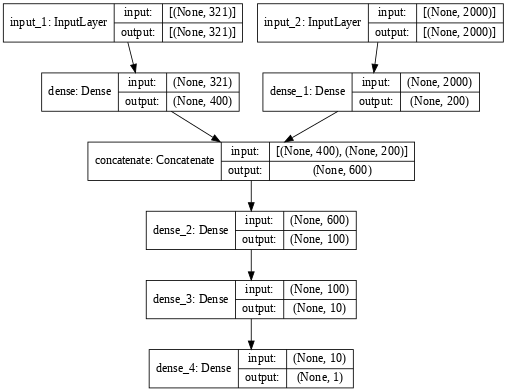

In [ ]:
input1 = Input((x_train_n.shape[1],))
input2 = Input((x_train_t.shape[1],))

x1=Dense(400, activation='relu')(input1)
#x1=Dropout(0.2)(x1)
x2=Dense(200, activation='relu')(input2)
#x2=Dropout(0.2)(x2)

x=concatenate([x1,x2])

x=Dense(100, activation='relu')(x)
#x=Dropout(0.2)(x)
x=Dense(10, activation='relu')(x)
x=Dense(1, activation='linear')(x)

model=Model((input1,input2),x)

plot_model(model, dpi=60, show_shapes=True)

In [ ]:
def on_epoch_end(epoch, logs):
  pred = model.predict([x_train_n_val, x_train_t_val]) #Полуаем выход сети на проверочно выборке
  predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = yScaler.inverse_transform(y_train_sc_val).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
  delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
  absDelta = abs(delta) #Берём модуль отклонения
  print("Эпоха", epoch, "усреднённая ошибка в миллионах рублей:", round(sum(absDelta) / (1e+6 * len(absDelta)),3)) #Выводим усреднённую ошибку в миллионах рублей

# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
model.compile(optimizer='Adam', loss='mse')
history=model.fit([x_train_n, x_train_t], y_train_sc, epochs=50, batch_size=128, validation_data=([x_train_n_val, x_train_t_val], y_train_sc_val), verbose=0, callbacks=[pltMae])
print()
print('Меняем шаг обучения на 1e-4')
model.compile(optimizer=Adam(lr=0.0001), loss='mse')
history = model.fit([x_train_n, x_train_t], y_train_sc, epochs=50, batch_size=128, validation_data=([x_train_n_val, x_train_t_val], y_train_sc_val), verbose=0, callbacks=[pltMae])
print()
print('Меняем шаг обучения на 1e-5')
model.compile(optimizer=Adam(lr=0.00001), loss='mse')
history = model.fit([x_train_n, x_train_t], y_train_sc, epochs=50, batch_size=128, validation_data=([x_train_n_val, x_train_t_val], y_train_sc_val), verbose=0, callbacks=[pltMae])

Эпоха 0 усреднённая ошибка в миллионах рублей: 1.621
Эпоха 1 усреднённая ошибка в миллионах рублей: 1.427
Эпоха 2 усреднённая ошибка в миллионах рублей: 1.339
Эпоха 3 усреднённая ошибка в миллионах рублей: 1.376
Эпоха 4 усреднённая ошибка в миллионах рублей: 2.017
Эпоха 5 усреднённая ошибка в миллионах рублей: 1.383
Эпоха 6 усреднённая ошибка в миллионах рублей: 1.348
Эпоха 7 усреднённая ошибка в миллионах рублей: 1.16
Эпоха 8 усреднённая ошибка в миллионах рублей: 1.296
Эпоха 9 усреднённая ошибка в миллионах рублей: 1.352
Эпоха 10 усреднённая ошибка в миллионах рублей: 1.087
Эпоха 11 усреднённая ошибка в миллионах рублей: 1.131
Эпоха 12 усреднённая ошибка в миллионах рублей: 2.247
Эпоха 13 усреднённая ошибка в миллионах рублей: 1.564
Эпоха 14 усреднённая ошибка в миллионах рублей: 1.139
Эпоха 15 усреднённая ошибка в миллионах рублей: 1.056
Эпоха 16 усреднённая ошибка в миллионах рублей: 1.717
Эпоха 17 усреднённая ошибка в миллионах рублей: 1.231
Эпоха 18 усреднённая ошибка в миллионах

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Эпоха 0 усреднённая ошибка в миллионах рублей: 0.921
Эпоха 1 усреднённая ошибка в миллионах рублей: 0.905
Эпоха 2 усреднённая ошибка в миллионах рублей: 0.906
Эпоха 3 усреднённая ошибка в миллионах рублей: 0.903
Эпоха 4 усреднённая ошибка в миллионах рублей: 0.887
Эпоха 5 усреднённая ошибка в миллионах рублей: 0.87
Эпоха 6 усреднённая ошибка в миллионах рублей: 0.865
Эпоха 7 усреднённая ошибка в миллионах рублей: 0.895
Эпоха 8 усреднённая ошибка в миллионах рублей: 0.875
Эпоха 9 усреднённая ошибка в миллионах рублей: 0.887
Эпоха 10 усреднённая ошибка в миллионах рублей: 0.873
Эпоха 11 усреднённая ошибка в миллионах рублей: 0.862
Эпоха 12 усреднённая ошибка в миллионах рублей: 0.887
Эпоха 13 усреднённая ошибка в миллионах рублей: 0.887
Эпоха 14 усреднённая ошибка в миллионах рублей: 0.875
Эпоха 15 усреднённая ошибка в миллионах рублей: 0.875
Эпоха 16 усреднённая ошибка в миллионах рублей: 0.874
Эпоха 17 усреднённая ошибка в миллионах рублей: 0.869
Эпоха 18 усреднённая ошибка в миллионах

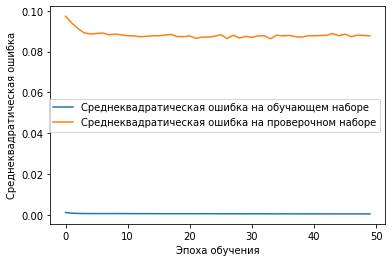

In [ ]:
#ВЫводим графики ошибки
plt.plot(history.history['loss'], 
         label='Среднеквадратическая ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Среднеквадратическая ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Среднеквадратическая ошибка')
plt.legend()
plt.show()